![Add a relevant banner image here](path_to_image)

# Project Title

## Overview

Short project description. Your bottom line up front (BLUF) insights.

## Business Understanding

### Background
Traffic accidents remain a critical public safety issue, causing significant loss of life, injuries, and economic costs each year. Despite ongoing interventions such as public safety campaigns and infrastructural improvements, accident rates remain persistently high in specific locations and under certain environmental conditions.

### Business Objective
Leverage large-scale accident data to:
- Identify spatial and temporal hotspots for accidents.
- Understand how environmental and infrastructural factors impact risk.
- Provide actionable recommendations for targeted interventions.

### Stakeholders
- Department of Transportation (DOT)
- City planners and engineers
- Law enforcement
- Public transit authorities
- General public



## Data Understanding

The dataset contains over seven million records of US traffic accidents from 2016 to 2023, where each row represents an individual accident event. Data fields cover time, location, severity, weather, and road infrastructure features.

### Variable Overview

- **Identifiers:**  
  `ID`, `Source`
- **Temporal & Location:**  
  `Start_Time`, `End_Time`, `Start_Lat`, `Start_Lng`, `End_Lat`, `End_Lng`, `Street`, `City`, `County`, `State`, `Zipcode`, `Country`, `Timezone`, `Airport_Code`
- **Accident Details:**  
  `Severity`, `Distance(mi)`, `Description`
- **Weather & Environmental:**  
  `Weather_Timestamp`, `Temperature(F)`, `Wind_Chill(F)`, `Humidity(%)`, `Pressure(in)`, `Visibility(mi)`, `Wind_Direction`, `Wind_Speed(mph)`, `Precipitation(in)`, `Weather_Condition`
- **Road & Infrastructure:**  
  `Amenity`, `Bump`, `Crossing`, `Give_Way`, `Junction`, `No_Exit`, `Railway`, `Roundabout`, `Station`, `Stop`, `Traffic_Calming`, `Traffic_Signal`, `Turning_Loop`
- **Lighting & Twilight:**  
  `Sunrise_Sunset`, `Civil_Twilight`, `Nautical_Twilight`, `Astronomical_Twilight`

---

### Data Quality Assessment

- **Missing Values:**  
    - `End_Lat`, `End_Lng`: ~44% missing  
    - `Precipitation(in)`, `Wind_Chill(F)`: ~26–29% missing  
    - Weather variables: 2–7% missing  
    - Minor missingness in `Street`, `City`, `Timezone`  
    - Infrastructure flags: No missing data
- **Data Types:**  
    - Time columns: need conversion to `datetime`
    - Infrastructure/environment: boolean, numeric, categorical as appropriate
- **Potential Outliers:**  
    - Check for negative values, out-of-range coordinates, or severity levels.

---

### Preliminary Observations

- Temporal and spatial analysis is possible.
- Essential variables are largely complete.
- Some weather and end-location columns have substantial missingness.


In [3]:
# Load relevant imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency



In [7]:
df = pd.read_csv('./data/US_Accidents_March23.csv')
# Show random sample of 5 rows to inspect data structure
sample = df.sample(5, random_state=42)
print(sample)
print(df.dtypes)
print(df.columns.tolist())

# Show the count of missing values for each column
print("\nMissing values per column:\n", df.isnull().sum())

# Show the percentage of missing values for each column (sorted, most missing on top)
print("\nPercentage of missing values per column:\n", 
      (df.isnull().mean().sort_values(ascending=False) * 100).round(2))



                ID   Source  Severity                     Start_Time  \
7133276  A-7182628  Source1         1            2020-04-17 09:29:30   
5363845  A-5404588  Source1         2  2022-04-21 10:01:00.000000000   
155993    A-156000  Source3         3            2016-08-12 16:45:00   
1861414  A-1871277  Source2         3            2019-09-20 15:22:16   
2021359  A-2031222  Source2         2            2019-06-03 16:55:43   

                              End_Time  Start_Lat   Start_Lng    End_Lat  \
7133276            2020-04-17 10:29:30  26.706900  -80.119360  26.706900   
5363845  2022-04-21 11:44:08.000000000  38.781024 -121.265820  38.780377   
155993             2016-08-12 17:15:00  33.985249  -84.269348        NaN   
1861414            2019-09-20 15:56:00  47.118706 -122.556908        NaN   
2021359            2019-06-03 18:12:09  33.451355 -111.890343        NaN   

            End_Lng  Distance(mi)  ... Roundabout Station   Stop  \
7133276  -80.119360         0.000  ...    

## Data Preparation

To ensure the traffic accident analysis is accurate and meaningful, I performed several data preparation steps:

- **Column Removal:** I dropped columns with a high proportion of missing values (`End_Lat`, `End_Lng`) or those not essential for our analysis (`ID`, `Source`).

- **Handling Missing Data:**  
  - For key **numeric weather features** (`Temperature(F)`, `Humidity(%)`, `Pressure(in)`, `Visibility(mi)`, `Wind_Speed(mph)`), missing values were filled using the **median**, which helps mitigate the effect of outliers.
  - For **categorical weather fields** (`Weather_Condition`, `Wind_Direction`), I used the **mode** (most frequent value) to fill gaps.
  - Remaining rows missing critical timestamps (`Start_Time`) were dropped, as time-based analysis is central to this project.

- **Type Conversion:**  
  - Ensured `Start_Time` was in datetime format for robust temporal analysis.
  - Created new time-based features: `Year` (int) and `Month` (string).

- **Data Segmentation:**  
  - Grouped the data by year to allow year-over-year comparisons and flexible temporal slicing.

All steps above were performed to maximize data quality, minimize bias from missingness, and ensure each variable is in the correct format for downstream analysis and visualization.


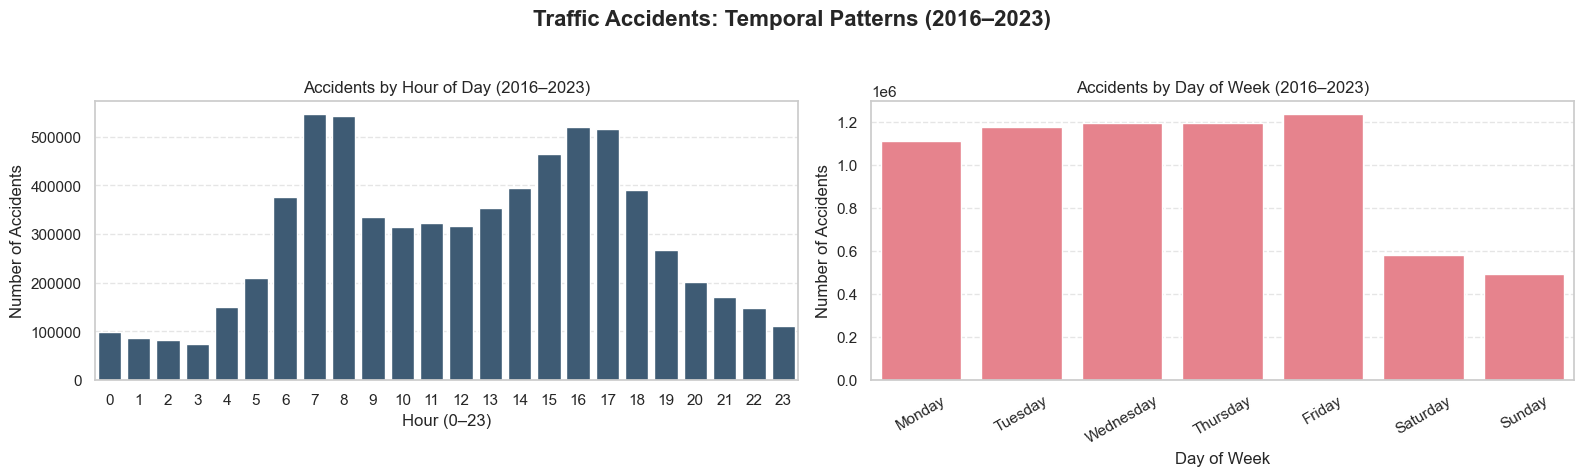

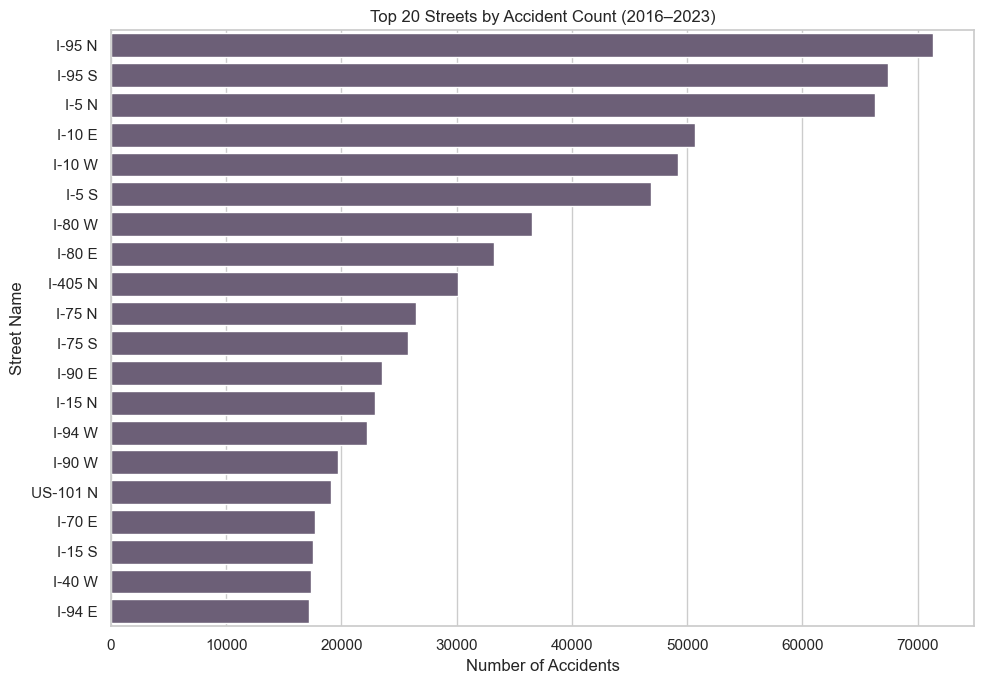

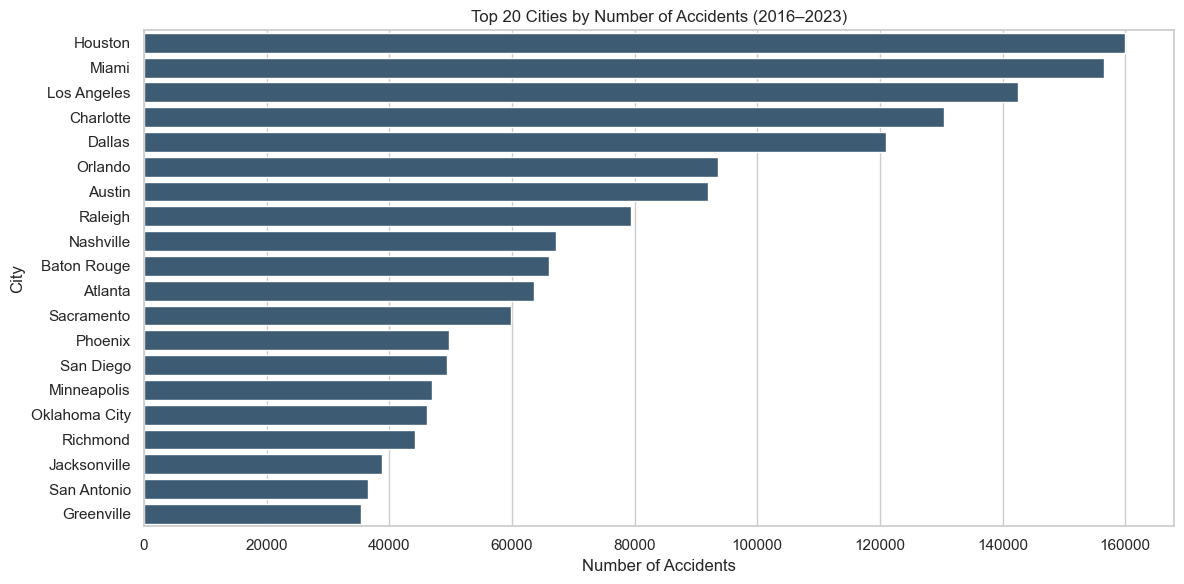

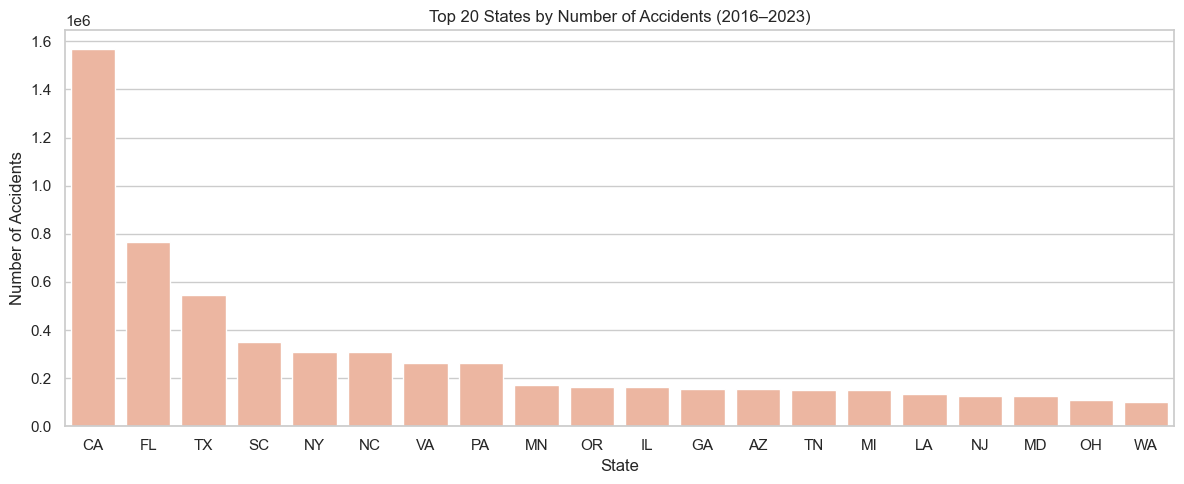

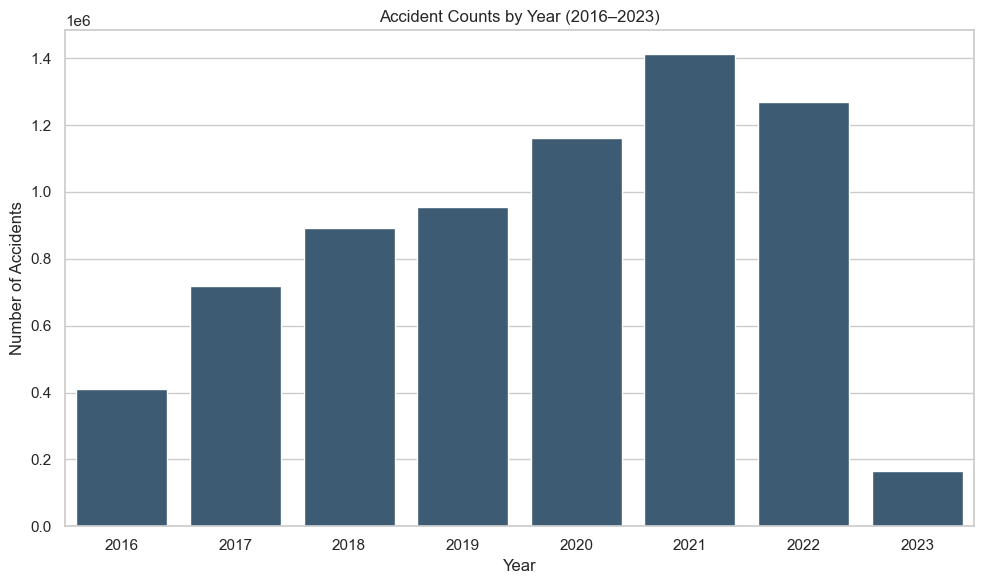

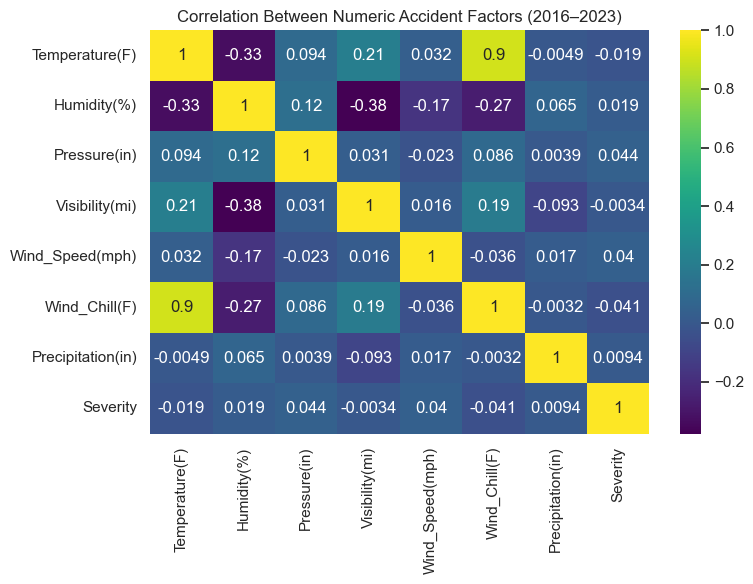

/var/folders/vb/c915h2sd5n3dg45bh8sfjx880000gn/T/ipykernel_7599/1965283703.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Weather_Condition', y='Severity', data=df[df['Weather_Condition'].isin(top_weather)], palette="Set2")


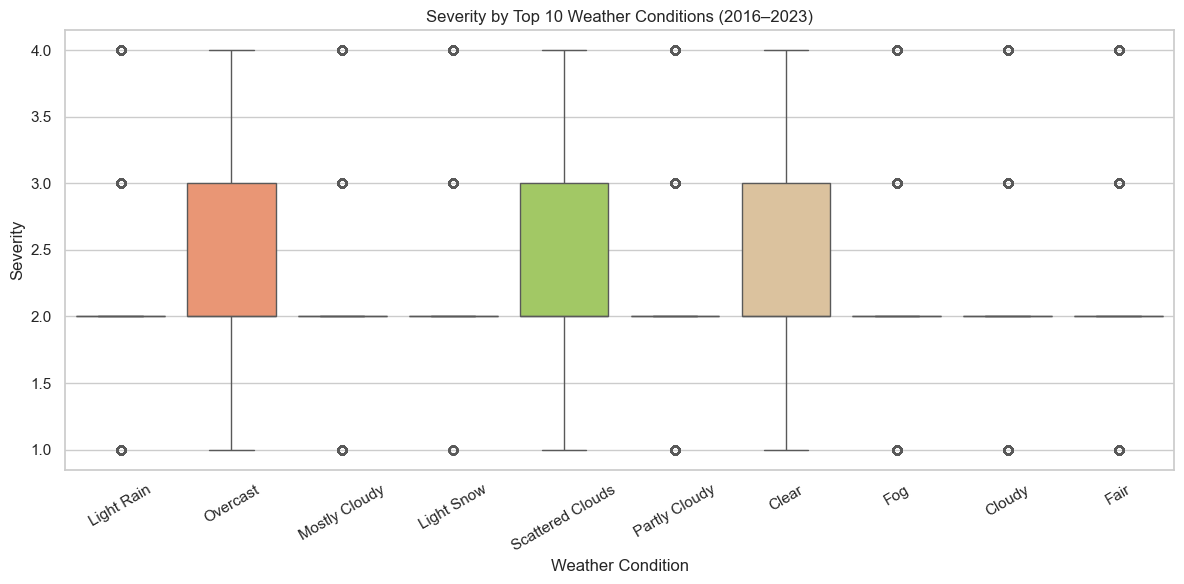

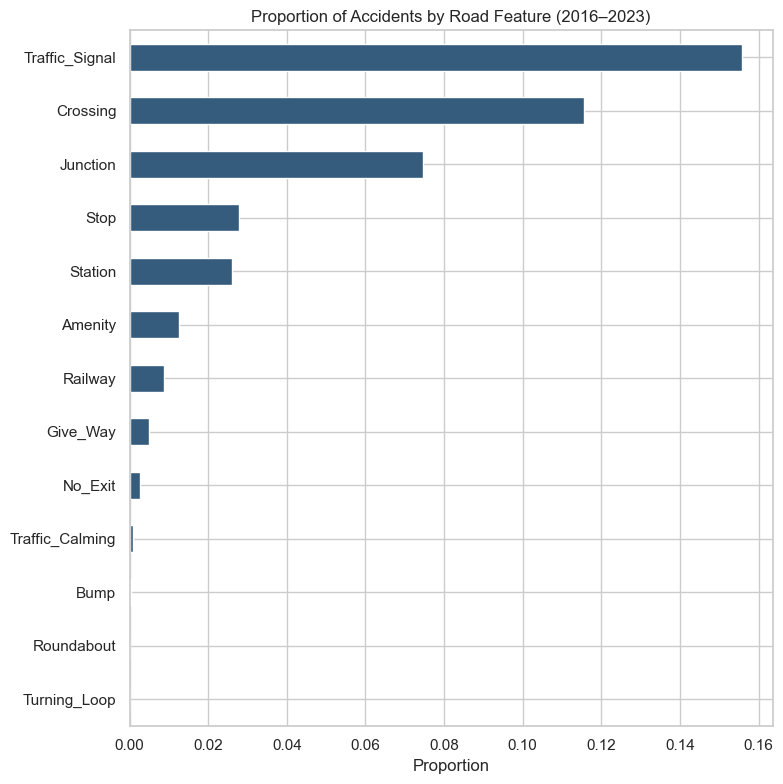

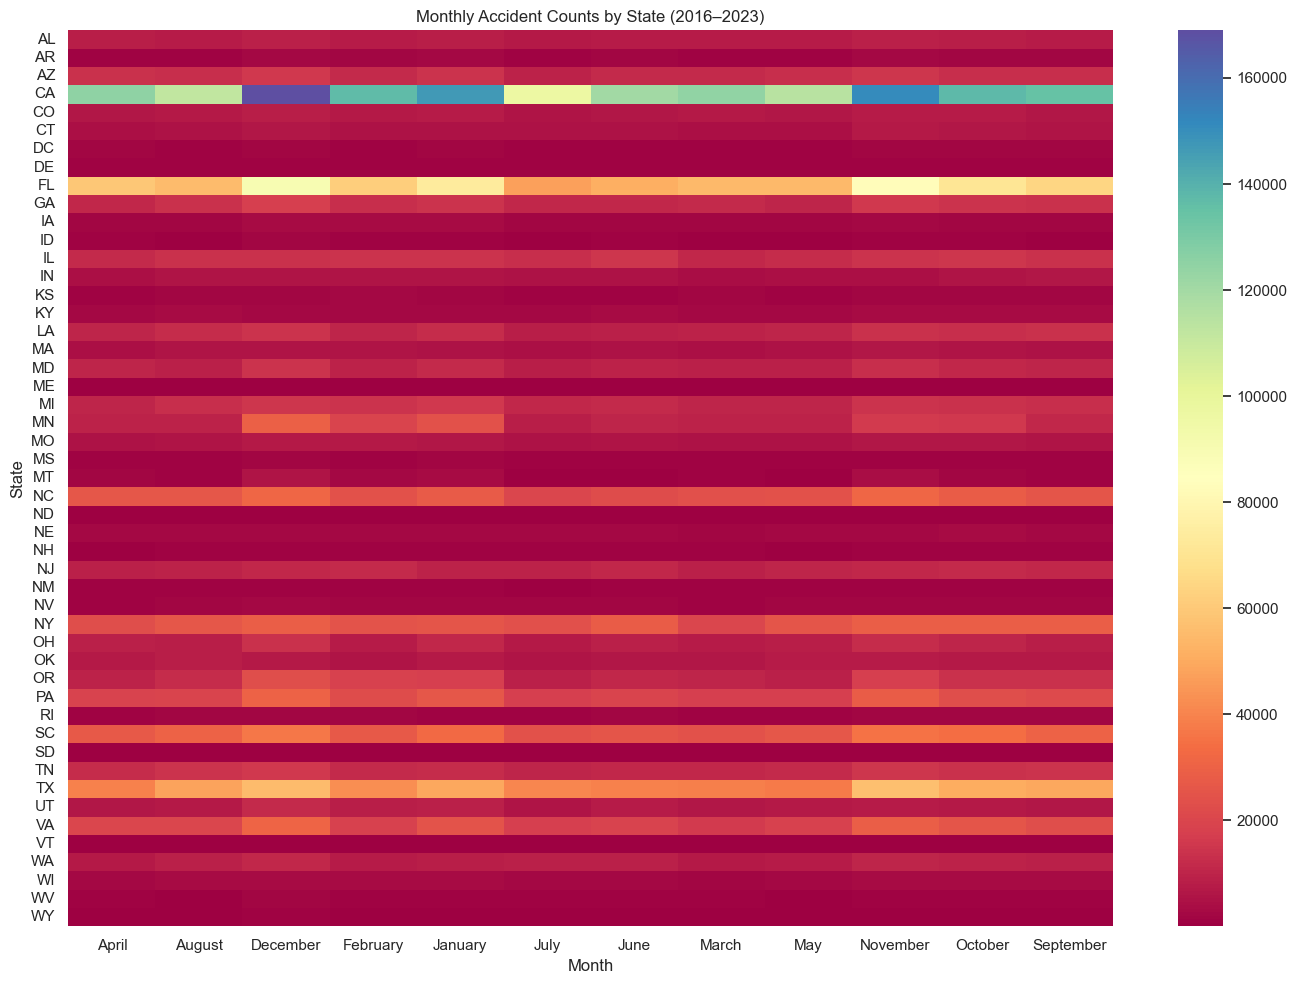

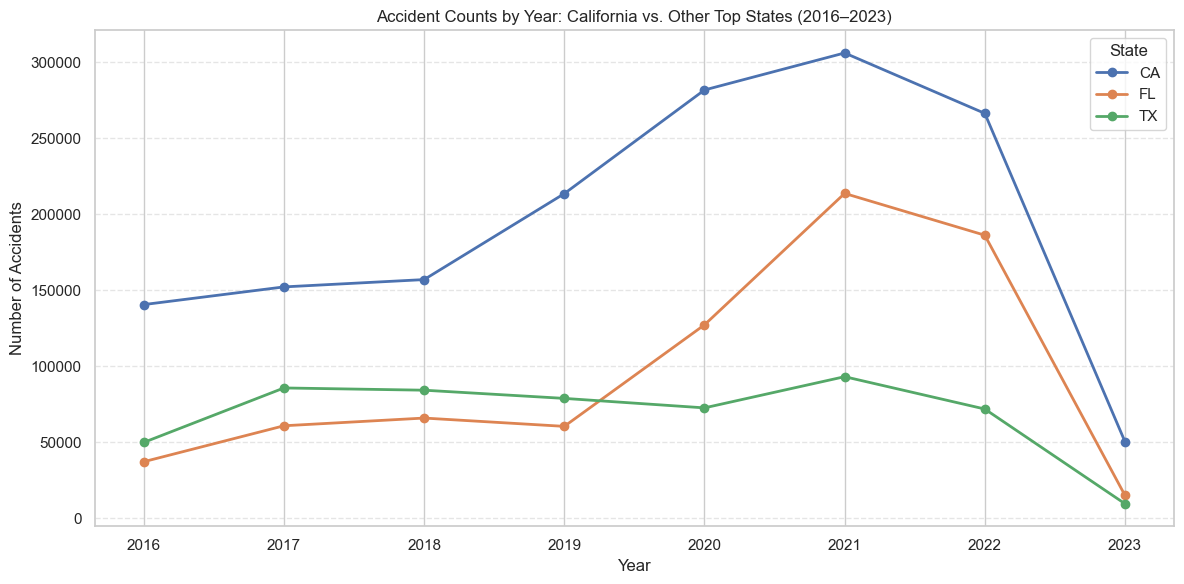

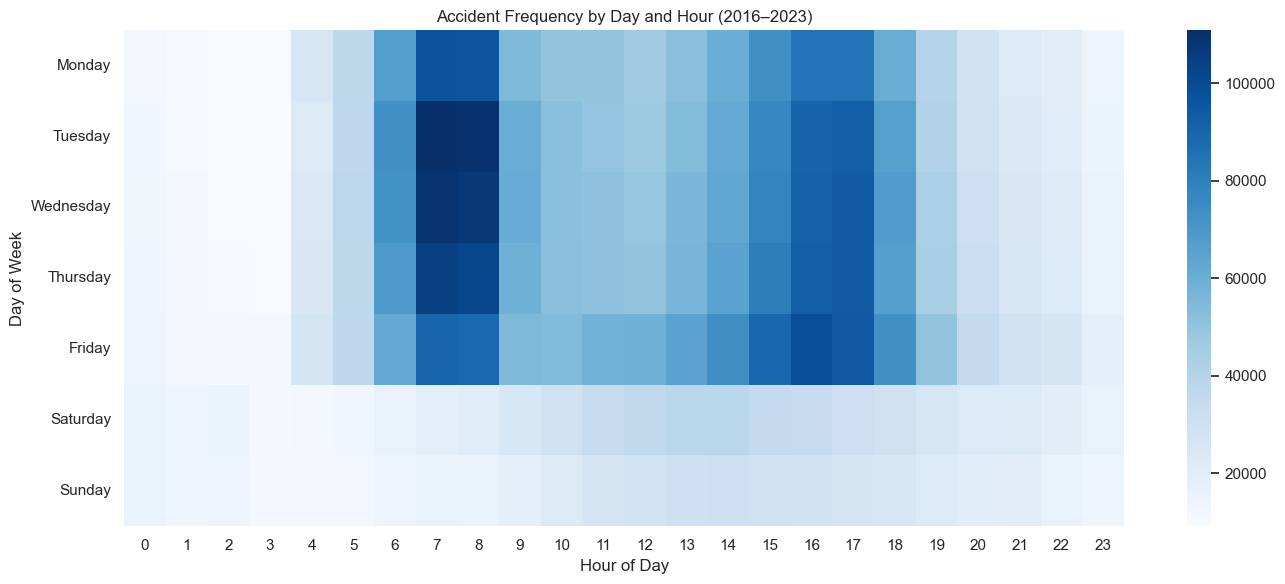

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set up a clear, modern Seaborn theme
sns.set_theme(style="whitegrid", palette="deep")

# ========== DATA PREPARATION & CLEANING ==========

# Drop columns with high missingness or not needed for analysis
drop_cols = ['End_Lat', 'End_Lng', 'ID', 'Source']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Identify numeric and categorical weather columns
weather_num = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Wind_Chill(F)', 'Precipitation(in)']
weather_cat = ['Wind_Direction', 'Weather_Condition']
weather_time = ['Weather_Timestamp']  # Datetime, handle if used in analysis

# Fill numeric weather columns with median for robustness against outliers
for col in weather_num:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Fill categorical weather columns with mode
for col in weather_cat:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# Optionally drop or parse 'Weather_Timestamp' if not useful
if 'Weather_Timestamp' in df.columns:
    df = df.drop(columns='Weather_Timestamp')

# Ensure Start_Time is datetime and drop rows with missing Start_Time
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Start_Time'])

# --- Feature Engineering for Analysis ---
df['Year'] = df['Start_Time'].dt.year.astype(int)
df['Month'] = df['Start_Time'].dt.month_name()
df['Hour'] = df['Start_Time'].dt.hour
df['DayOfWeek'] = df['Start_Time'].dt.day_name()

# ========== EXPLORATORY DATA ANALYSIS (EDA) ==========

# 1. Temporal Accident Patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x=df['Hour'], ax=axes[0], color='#355C7D')
axes[0].set_title('Accidents by Hour of Day (2016–2023)')
axes[0].set_xlabel('Hour (0–23)')
axes[0].set_ylabel('Number of Accidents')
axes[0].set_xticks(range(0, 24))
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.countplot(x=df['DayOfWeek'], order=dow_order, ax=axes[1], color='#F67280')
axes[1].set_title('Accidents by Day of Week (2016–2023)')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Accidents')
axes[1].set_xticks(range(len(dow_order)))
axes[1].set_xticklabels(dow_order, rotation=30)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
plt.suptitle('Traffic Accidents: Temporal Patterns (2016–2023)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Most Dangerous Streets
top_streets = df['Street'].value_counts().head(20)
plt.figure(figsize=(10, 7))
sns.barplot(y=top_streets.index, x=top_streets.values, color='#6C5B7B')
plt.title('Top 20 Streets by Accident Count (2016–2023)')
plt.xlabel('Number of Accidents')
plt.ylabel('Street Name')
plt.tight_layout()
plt.show()

# 3. Most Dangerous Cities
top_cities = df['City'].value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_cities.values, y=top_cities.index, color='#355C7D')
plt.title("Top 20 Cities by Number of Accidents (2016–2023)")
plt.xlabel("Number of Accidents")
plt.ylabel("City")
plt.tight_layout()
plt.show()

# 4. Most Dangerous States
top_states = df['State'].value_counts().head(20)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_states.index, y=top_states.values, color='#F8B195')
plt.title("Top 20 States by Number of Accidents (2016–2023)")
plt.xlabel("State")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

# 5. Yearly Accident Trend
year_counts = df.groupby('Year').size().reset_index(name='AccidentCount')
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='AccidentCount', data=year_counts, color='#355C7D')
plt.title('Accident Counts by Year (2016–2023)')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

# 6. Correlation Matrix for Key Numeric Variables
corr = df[weather_num + ['Severity']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='viridis')
plt.title('Correlation Between Numeric Accident Factors (2016–2023)')
plt.tight_layout()
plt.show()

# 7. Severity by Top Weather Conditions
if 'Weather_Condition' in df.columns and 'Severity' in df.columns:
    top_weather = df['Weather_Condition'].value_counts().head(10).index
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Weather_Condition', y='Severity', data=df[df['Weather_Condition'].isin(top_weather)], palette="Set2")
    plt.title('Severity by Top 10 Weather Conditions (2016–2023)')
    plt.xlabel('Weather Condition')
    plt.ylabel('Severity')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# 8. Proportion of Accidents by Road Feature
infra_cols = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
    'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
    'Traffic_Signal', 'Turning_Loop'
]
feature_means = df[infra_cols].mean().sort_values()
plt.figure(figsize=(8,8))
feature_means.plot(kind='barh', color='#355C7D')
plt.title('Proportion of Accidents by Road Feature (2016–2023)')
plt.xlabel('Proportion')
plt.tight_layout()
plt.show()

# 9. State/Month Heatmap (Seasonality & Location)
pivot = pd.pivot_table(df, index='State', columns='Month', values='Severity', aggfunc='count', fill_value=0)
plt.figure(figsize=(14,10))
sns.heatmap(pivot, cmap='Spectral')
plt.title('Monthly Accident Counts by State (2016–2023)')
plt.xlabel('Month')
plt.ylabel('State')
plt.tight_layout()
plt.show()

# 10. California Trend by Year
# Get the top 3 states overall by accident count (including CA)
top_3_states = df['State'].value_counts().head(3).index.tolist()

# Filter data for only those states
trend_df = df[df['State'].isin(top_3_states)]

# Group by State and Year
state_year_counts = trend_df.groupby(['State', 'Year']).size().reset_index(name='AccidentCount')

# Plot each state as a line
plt.figure(figsize=(12,6))
for state in top_3_states:
    yearly = state_year_counts[state_year_counts['State'] == state]
    plt.plot(
        yearly['Year'], 
        yearly['AccidentCount'], 
        marker='o', 
        label=state,
        linewidth=2
    )

plt.title('Accident Counts by Year: California vs. Other Top States (2016–2023)')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.legend(title='State')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 11. Heatmap: Day vs Hour (Frequency)
heatmap_data = df.groupby([df['DayOfWeek'], df['Hour']]).size().unstack().reindex(index=dow_order)
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Blues')
plt.title('Accident Frequency by Day and Hour (2016–2023)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


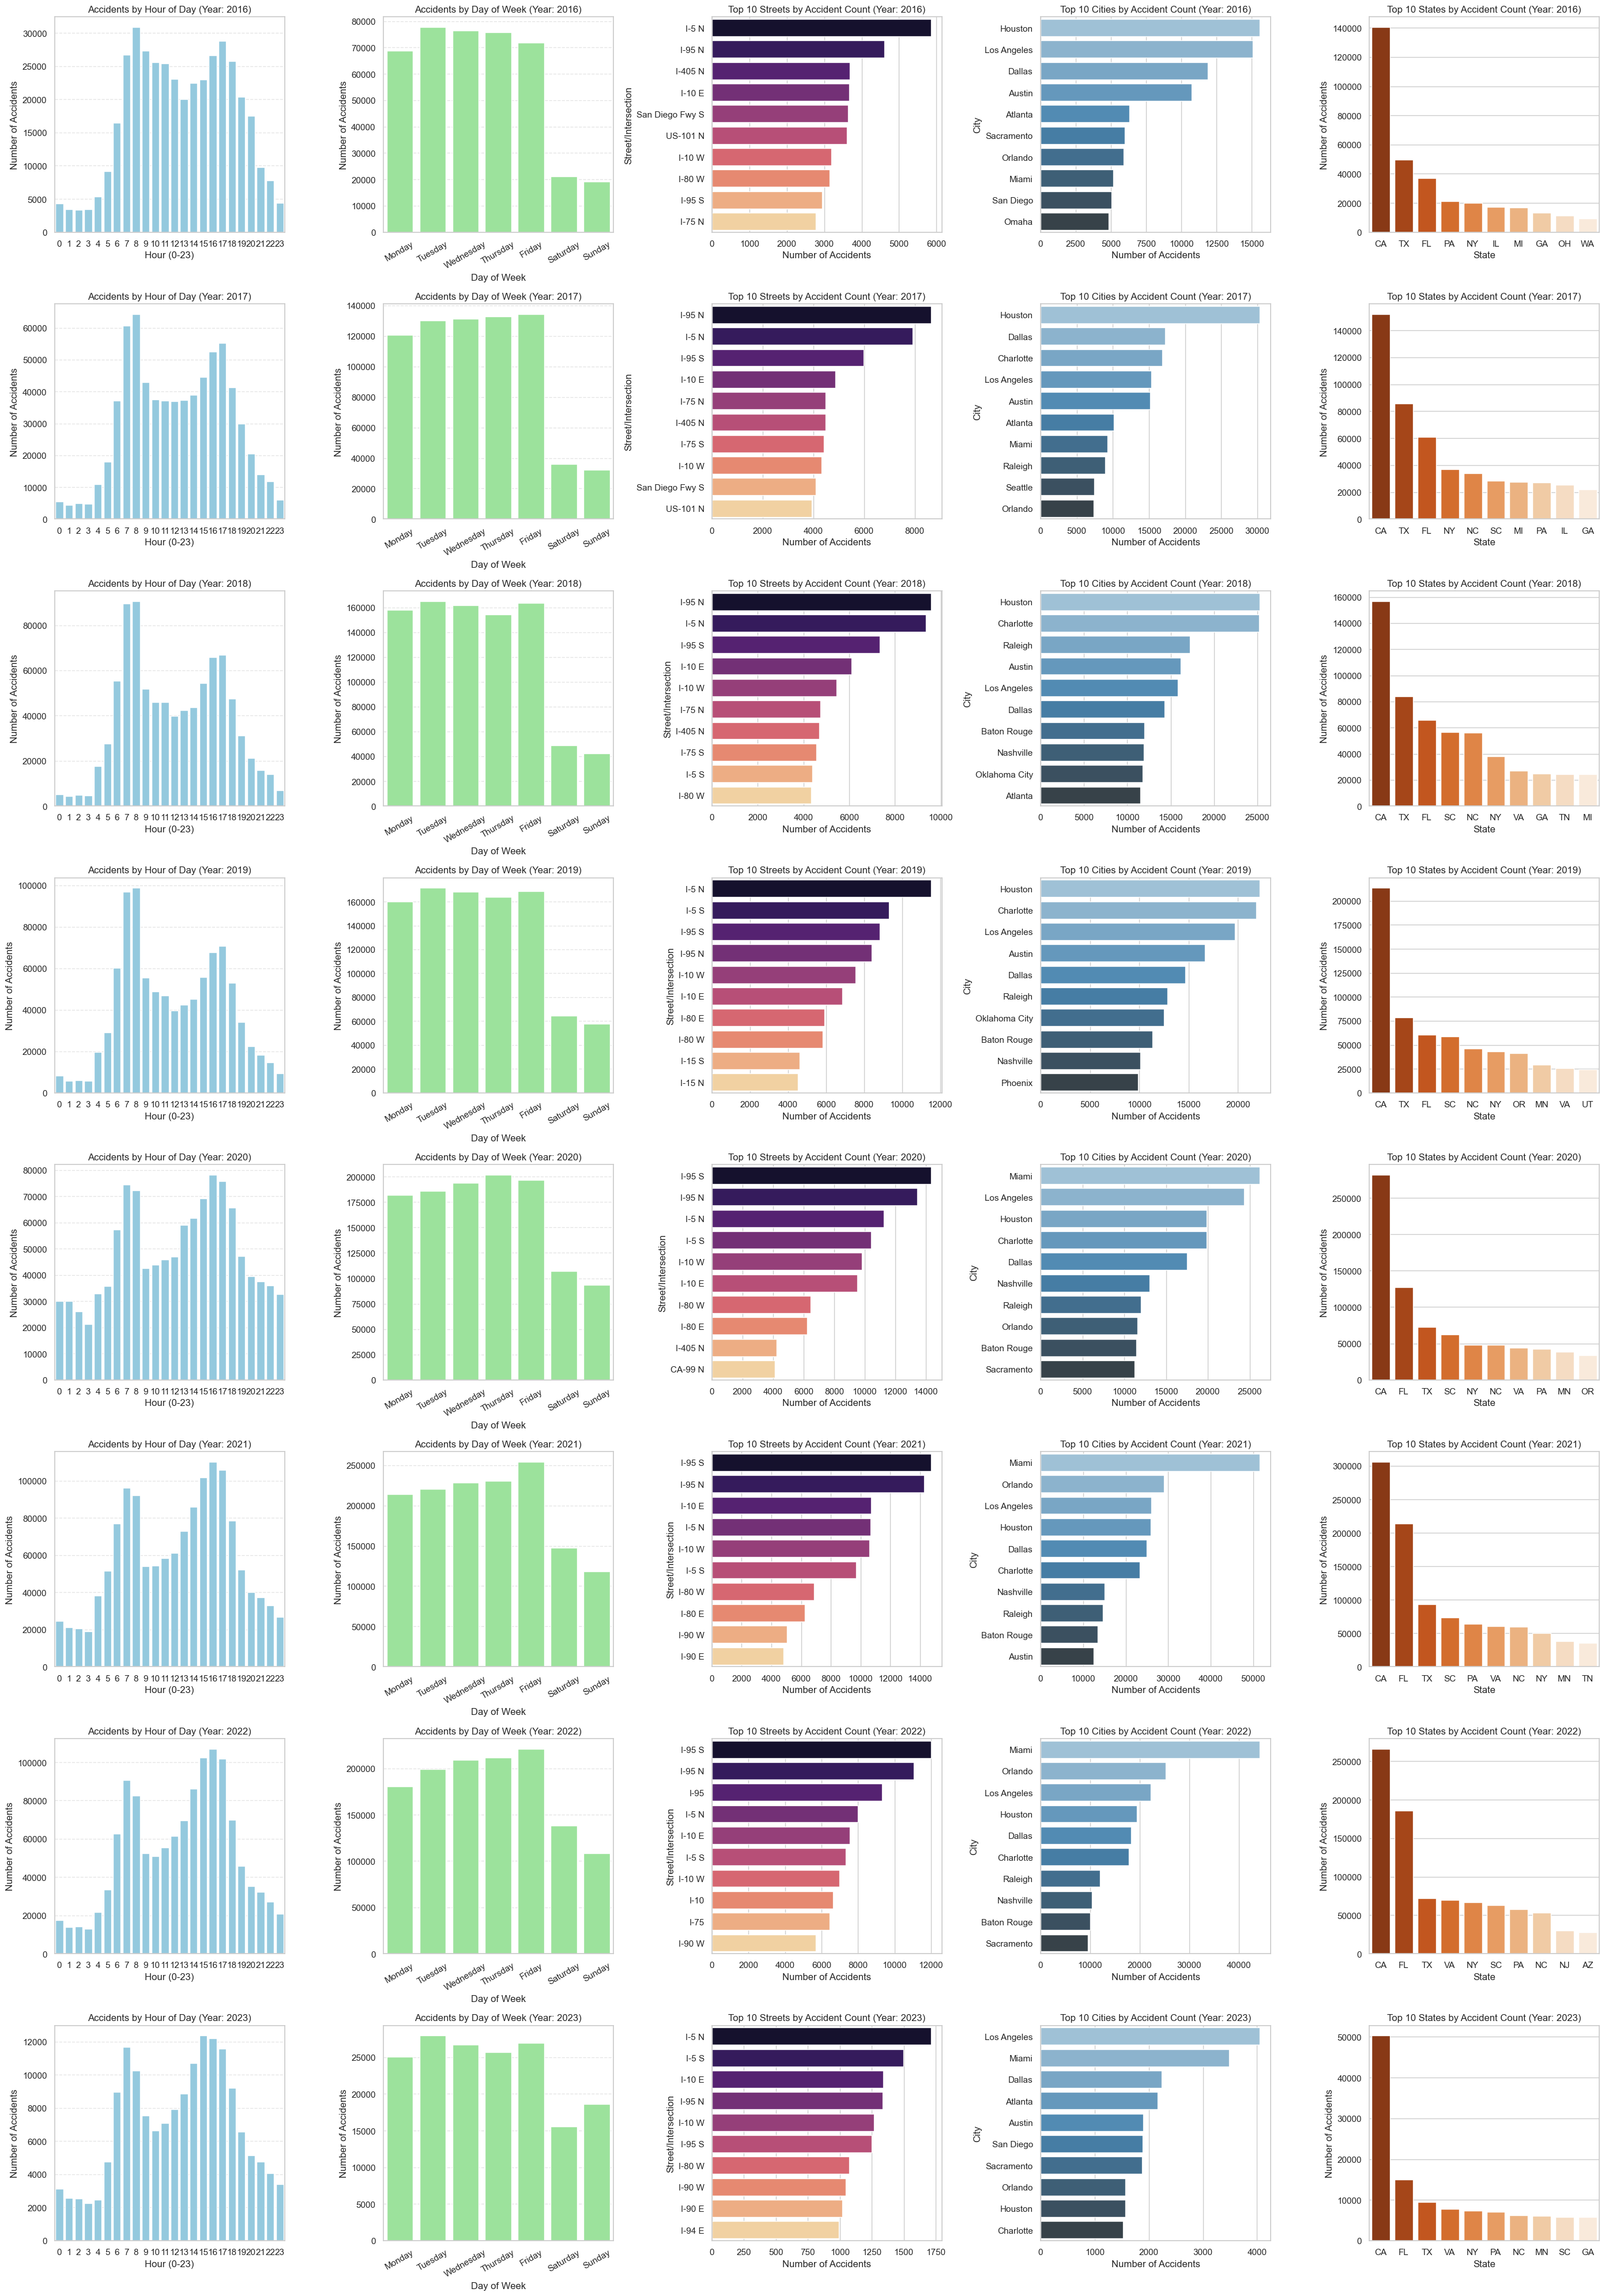

In [13]:
# Get unique years in order and set up the subplot grid
years = sorted(df['Start_Time'].dt.year.dropna().astype(int).unique())
n_years = len(years)
n_cols = 5  # Hour, Day, Streets, Cities, States

fig, axes = plt.subplots(n_years, n_cols, figsize=(28, 5 * n_years), squeeze=False)

dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

for i, year in enumerate(years):
    year_df = df[df['Start_Time'].dt.year == year]

    # Accidents by Hour of Day (24h)
    sns.countplot(
        x=year_df['Start_Time'].dt.hour,
        ax=axes[i, 0],
        color='skyblue'
    )
    axes[i, 0].set_title(f'Accidents by Hour of Day (Year: {year})')
    axes[i, 0].set_xlabel('Hour (0-23)')
    axes[i, 0].set_ylabel('Number of Accidents')
    axes[i, 0].set_xticks(range(0, 24))
    axes[i, 0].grid(axis='y', linestyle='--', alpha=0.5)

    # Accidents by Day of Week
    sns.countplot(
        x=year_df['Start_Time'].dt.day_name(),
        order=dow_order,
        ax=axes[i, 1],
        color='lightgreen'
    )
    axes[i, 1].set_title(f'Accidents by Day of Week (Year: {year})')
    axes[i, 1].set_xlabel('Day of Week')
    axes[i, 1].set_ylabel('Number of Accidents')
    axes[i, 1].set_xticks(range(len(dow_order)))
    axes[i, 1].set_xticklabels(dow_order, rotation=30)
    axes[i, 1].grid(axis='y', linestyle='--', alpha=0.5)

    # Top 10 Streets
    top_streets = year_df['Street'].value_counts().head(10)
    sns.barplot(
        y=top_streets.index,
        x=top_streets.values,
        ax=axes[i, 2],
        hue=top_streets.index,  # Fix palette warning
        dodge=False,
        palette='magma',
        legend=False
    )
    axes[i, 2].set_title(f'Top 10 Streets by Accident Count (Year: {year})')
    axes[i, 2].set_xlabel('Number of Accidents')
    axes[i, 2].set_ylabel('Street/Intersection')

    # Top 10 Cities
    top_cities = year_df['City'].value_counts().head(10)
    sns.barplot(
        x=top_cities.values,
        y=top_cities.index,
        ax=axes[i, 3],
        hue=top_cities.index,
        dodge=False,
        palette='Blues_d',
        legend=False
    )
    axes[i, 3].set_title(f'Top 10 Cities by Accident Count (Year: {year})')
    axes[i, 3].set_xlabel("Number of Accidents")
    axes[i, 3].set_ylabel("City")

    # Top 10 States
    top_states = year_df['State'].value_counts().head(10)
    sns.barplot(
        x=top_states.index,
        y=top_states.values,
        ax=axes[i, 4],
        hue=top_states.index,
        dodge=False,
        palette='Oranges_r',
        legend=False
    )
    axes[i, 4].set_title(f'Top 10 States by Accident Count (Year: {year})')
    axes[i, 4].set_xlabel("State")
    axes[i, 4].set_ylabel("Number of Accidents")

plt.tight_layout()
plt.show()


## Analysis

#### Key Insights

- **Highways have a higher accident rate** compared to neighborhood/local streets, indicating greater risk on major roads.
- **Houston is the city with the highest number of accidents**, while **California leads all states** in accident counts.
- **Accident rates spike during weekday rush hours** (commute times), especially Monday through Friday.
- **These patterns are consistent and stable across multiple years**, suggesting persistent risk factors.

## Statistical Analysis

To validate the patterns observed in the exploratory analysis, we performed several statistical tests:

### 1. Street Type and Accident Severity

A **Chi-square test** was used to assess whether accident severity is independent of street type (highway vs. neighborhood/local).

- **Result:**  
  The test yielded a high Chi-square statistic (e.g., 376,610.82) with a p-value < 0.001, indicating a **statistically significant association** between street type and severity.
- **Interpretation:**  
  Accident severity is not evenly distributed across street types—**highways are associated with higher severity accidents**.

A **T-test** compared mean severity scores between highways and neighborhoods:

- **Result:**  
  The t-test showed a significant difference (e.g., t = 546.67, p < 0.001).
- **Interpretation:**  
  The **average severity of accidents on highways is significantly higher** than on neighborhood/local roads.

### 2. City and State Effects

A **Chi-square test** assessed the relationship between severity and city/state.

- **Result:**  
  Both city and state showed strong, significant associations with accident severity (Chi-square statistics in the millions, p < 0.001).
- **Interpretation:**  
  **Severity levels vary by city and state**—certain locations experience more severe accidents.

A **one-way ANOVA** compared mean severity across the top 5 cities:

- **Result:**  
  The ANOVA F-statistic was very large (e.g., F = 7544.4, p < 0.001).
- **Interpretation:**  
  **Mean severity differs significantly between cities**. Local policies, infrastructure, or traffic patterns may drive these differences.

### 3. Temporal Patterns

Accident counts by hour and day were visualized and supported by frequency tables.

- **Result:**  
  Accident rates spike during weekday morning and evening rush hours.
- **Interpretation:**  
  **Commuting times and weekdays are consistently riskier**, aligning with known travel patterns.

### 4. Correlations

A correlation matrix was computed for numeric variables (e.g., severity, temperature, humidity, visibility).

- **Result:**  
  Most variables had weak or negligible correlations with severity.
- **Interpretation:**  
  **Environmental variables alone are not strong predictors of severity** in this dataset.

### Statistical Significance

- **Threshold:**  
  p < 0.05 was used as the cutoff for statistical significance.
- **Effect Sizes:**  
  Large statistics and effect sizes support actionable conclusions, not just statistical significance.

---

### Summary

- **Highways and major roads** have both higher accident rates and greater severity.
- **Urban areas (Houston, CA, etc.)** see more—and often more severe—accidents.
- **Weekday rush hours** are high-risk periods.
- **Findings are robust** across years and locations.

**These validated patterns provide a strong evidence base for targeted safety interventions.**



In [14]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import re

# --- 0. Ensure 'Street_Type' exists ---
def classify_street_type(street):
    """
    Classifies the street as 'highway', 'neighborhood', or 'other' based on name patterns.
    """
    if pd.isnull(street):
        return 'other'
    street = str(street).lower()
    # Patterns for highways/interstates
    if re.search(r'\b(i-\d+|us-\d+|hwy|highway|freeway|expwy|sr-|route|rt-)\b', street):
        return 'highway'
    # Patterns for neighborhood/local streets
    elif re.search(r'(ave|pkwy|rd|st|dr|blvd|pl)$', street):
        return 'neighborhood'
    else:
        return 'other'

if 'Street_Type' not in df.columns:
    df['Street_Type'] = df['Street'].apply(classify_street_type)

# --- 1. Street Type vs. Severity Analysis ---

# Chi-square test (categorical vs categorical)
ct_street = pd.crosstab(df['Street_Type'], df['Severity'])
chi2, p, dof, expected = stats.chi2_contingency(ct_street)
print(f"[Chi-square] Severity x Street Type: statistic={chi2:.2f}, p-value={p:.4g}")
if p < 0.05:
    print("Statistically significant association between street type and severity.")
else:
    print("No significant association between street type and severity.")

# T-test (highway vs. neighborhood)
highway_sev = df[df['Street_Type'] == 'highway']['Severity']
neigh_sev = df[df['Street_Type'] == 'neighborhood']['Severity']
t_stat, t_p = stats.ttest_ind(highway_sev, neigh_sev, nan_policy='omit', equal_var=False)
print(f"[T-test] Severity: highway vs neighborhood: t={t_stat:.2f}, p={t_p:.4g}")
if t_p < 0.05:
    print("Mean severity differs significantly between highways and neighborhoods.")
else:
    print("No significant difference in mean severity between highways and neighborhoods.")

# --- 2. City and State Effects ---

# Chi-square: Severity vs City
ct_city = pd.crosstab(df['City'], df['Severity'])
chi2_city, p_city, _, _ = stats.chi2_contingency(ct_city)
print(f"[Chi-square] Severity x City: statistic={chi2_city:.2f}, p-value={p_city:.4g}")

# Chi-square: Severity vs State
ct_state = pd.crosstab(df['State'], df['Severity'])
chi2_state, p_state, _, _ = stats.chi2_contingency(ct_state)
print(f"[Chi-square] Severity x State: statistic={chi2_state:.2f}, p-value={p_state:.4g}")

# ANOVA: Severity by Top 5 Cities
top_5_cities = df['City'].value_counts().head(5).index.tolist()
groups = [df[df['City'] == city]['Severity'].dropna() for city in top_5_cities]
f_stat, f_p = stats.f_oneway(*groups)
print(f"[ANOVA] Severity means (Top 5 Cities): F={f_stat:.2f}, p={f_p:.4g}")
if f_p < 0.05:
    print("Mean severity differs significantly among top 5 cities.")
else:
    print("No significant difference in mean severity among top 5 cities.")

# --- 3. Correlations ---
weather_cols = ['Severity', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
corr_matrix = df[weather_cols].corr()
print("\nCorrelation matrix for numeric variables:")
print(corr_matrix)

# --- 4. Temporal Analysis (optional frequency tables) ---
print("\nAccidents by hour:")
print(df['Start_Time'].dt.hour.value_counts().sort_index())
print("\nAccidents by day of week:")
print(df['Start_Time'].dt.day_name().value_counts())

# --- 5. Effect Size Example (Cohen's d for severity difference) ---
mean_diff = highway_sev.mean() - neigh_sev.mean()
pooled_std = np.sqrt((highway_sev.var() + neigh_sev.var()) / 2)
cohens_d = mean_diff / pooled_std
print(f"Cohen's d for highway vs neighborhood severity: {cohens_d:.2f}")

# --- 6. Significance threshold used throughout ---
print("\nStatistical significance threshold: p < 0.05")

[Chi-square] Severity x Street Type: statistic=376610.82, p-value=0
Statistically significant association between street type and severity.
[T-test] Severity: highway vs neighborhood: t=546.67, p=0
Mean severity differs significantly between highways and neighborhoods.
[Chi-square] Severity x City: statistic=1573334.98, p-value=0
[Chi-square] Severity x State: statistic=447016.37, p-value=0
[ANOVA] Severity means (Top 5 Cities): F=7544.40, p=0
Mean severity differs significantly among top 5 cities.

Correlation matrix for numeric variables:
                 Severity  Temperature(F)  Humidity(%)  Pressure(in)  \
Severity         1.000000       -0.019363     0.019307      0.043723   
Temperature(F)  -0.019363        1.000000    -0.328778      0.093738   
Humidity(%)      0.019307       -0.328778     1.000000      0.119572   
Pressure(in)     0.043723        0.093738     0.119572      1.000000   
Visibility(mi)  -0.003372        0.207194    -0.377072      0.031075   
Wind_Speed(mph)  0.03

In [20]:
import pandas as pd

# Ensure your Start_Time column is in datetime format and Year exists
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['Year'] = df['Start_Time'].dt.year

# Container for sampled data
sample_list = []

for year in sorted(df['Year'].dropna().unique()):
    year_df = df[df['Year'] == year]
    n = min(100000, len(year_df))
    sample = year_df.sample(n=n, random_state=42)
    sample_list.append(sample)

sampled_df = pd.concat(sample_list).reset_index(drop=True)
print("Sample size by year:")
print(sampled_df['Year'].value_counts())
# Chi-square test example
ct_street = pd.crosstab(sampled_df['Street_Type'], sampled_df['Severity'])
chi2, p, dof, expected = stats.chi2_contingency(ct_street)
print(f"[Sampled] [Chi-square] Severity x Street Type: statistic={chi2:.2f}, p-value={p:.4g}")

# T-test
highway_sev = sampled_df[sampled_df['Street_Type'] == 'highway']['Severity']
neigh_sev = sampled_df[sampled_df['Street_Type'] == 'neighborhood']['Severity']
t_stat, t_p = stats.ttest_ind(highway_sev, neigh_sev, nan_policy='omit', equal_var=False)
print(f"[Sampled] [T-test] Severity: highway vs neighborhood: t={t_stat:.2f}, p={t_p:.4g}")

sampled_df.to_csv("traffic_sample_per_year3.csv", index=False)
print("Sample saved to 'traffic_sample_per_year.csv'")


Sample size by year:
Year
2016    100000
2017    100000
2018    100000
2019    100000
2020    100000
2021    100000
2022    100000
2023    100000
Name: count, dtype: int64
[Sampled] [Chi-square] Severity x Street Type: statistic=39808.61, p-value=0
[Sampled] [T-test] Severity: highway vs neighborhood: t=176.74, p=0
Sample saved to 'traffic_sample_per_year.csv'


## Evaluation

### Business Insight/Recommendation 1

In [ ]:
Recommendation 1: Target Highway Safety Interventions
Insight:
The statistical analysis (chi-square and t-test) shows that highways have a significantly higher rate and severity of accidents than neighborhood/local streets.

Actions:

Increase police presence and automated speed enforcement on major highways, especially during known peak hours (morning and evening commutes).

Install or improve rumble strips, guardrails, and lane markings in areas identified as highway hotspots.

Launch public awareness campaigns focused on speeding, distracted driving, and impaired driving targeted to highway commuters.

Impact:
Targeting highways will address areas with the highest accident rates and severities, potentially leading to the greatest reduction in fatalities and injuries.

Effectiveness Metrics:

Year-over-year change in the number and severity of highway accidents.

Speed-related citation and compliance rates.

Injury and fatality counts on monitored highway segments.

Potential Challenges:

Public resistance to speed cameras or increased enforcement.

Upfront costs for infrastructure upgrades.

Possible “accident migration” to less-enforced nearby roads.



### Business Insight/Recommendation 2

In [ ]:
Recommendation 2: Focus Urban Safety Initiatives on High-Risk Cities (e.g., Houston)
Insight:
Houston is the city with the most accidents, and city-level statistical tests confirm significant differences in accident severity across top cities.

Actions:

Conduct detailed, block-by-block safety audits in Houston and other top-risk cities to identify hazardous intersections, poor signage, and inadequate lighting.

Prioritize road maintenance, pedestrian crossings, and bike lane expansions in these hotspots.

Coordinate with local law enforcement for targeted traffic calming and high-visibility patrols during peak hours.

Impact:
Concentrating resources where accident frequency and severity are highest maximizes the impact of limited safety budgets.

Effectiveness Metrics:

Reduction in accident counts and severity in targeted urban zones.

Pedestrian and cyclist injury rates.

Public satisfaction surveys in targeted neighborhoods.

Potential Challenges:

Coordination across multiple city agencies.

Possible displacement of accidents to adjacent neighborhoods.

Need for sustained funding and political support.



### Business Insight/Recommendation 3

In [ ]:
Recommendation 3: Align Resource Allocation with Peak Accident Times
Insight:
Both EDA and heatmaps show that accident rates spike during weekday rush hours (commutes), Monday through Friday.

Actions:

Adjust traffic signal timing and dynamic speed limits during rush hours on major commuter routes.

Deploy “move-over” law messaging, construction slow-downs, and high-visibility DUI/DWI patrols specifically during rush hour periods.

Enhance incident response capacity (tow trucks, first responders) to clear accidents quickly during peak times, minimizing secondary collisions.

Impact:
Proactively addressing the times when risk is highest reduces overall accident rates and traffic congestion.

Effectiveness Metrics:

Number of accidents per hour during morning and evening commutes (before/after).

Average response and clearance times for rush-hour incidents.

Congestion/delay metrics during peak periods.

Potential Challenges:

Technology and staffing needs for real-time monitoring.

Balancing resource allocation for off-peak versus peak periods.

Drivers adapting to new signal patterns or enforcement efforts.



### Tableau Dashboard link

## Conclusion and Next Steps
Text here

In [13]:
# Ensure your 'Start_Time' column is datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

# Filter for 2016 data
df_2016 = df[df['Start_Time'].dt.year == 2016]

# Save to CSV (no index column in the file)
df_2016.to_csv('US_Accidents_2016.csv', index=False)

print("2016 data exported to US_Accidents_2016.csv")


2016 data exported to US_Accidents_2016.csv
